In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import simpleaudio as sa
from matplotlib.pyplot import figure
import math
import utility

In [2]:
"""FUNCTION: display_data() -- checking data contents (mono vs stereo)""" 
#works both mono & stereo
def display_data(audiofile, showgraphs = False):
    fs_in, data_in = wavfile.read(audiofile)
    print(f".Wav Contents = {data_in}")
    print(f".Wav Samples Length = {data_in.shape[0]}")
    print(f".Wav Channel(s) = {len(data_in.shape)}")
    length = data_in.shape[0] / fs_in
    print(f".Wav Length = {length}s")
    print(f"Sampling Rate= {fs_in} Hz")
    print(f"bit depth= {type(data_in[0])}")
    print(f"sampling rate = {fs_in} Hz, length = {data_in.shape[0]} samples => {data_in.shape[0]/fs_in} s, channels = {len(data_in.shape)}")

    if showgraphs == True:
        figure();
        plt.plot(data_in);
        plt.title(str(audiofile));
        plt.xlabel("Samples");
        plt.ylabel("Amplitude");
    print("-------------")

In [3]:
"""make stereo regardless"""
def makestereo(audiofile):
    stereodata = 0
    fs, data = wavfile.read(audiofile)
    chan_num = len(data.shape)
    if chan_num == 1:
        stereodata = np.stack((data, data), axis=-1)
    else: #if chan_num == 2, stereo
        stereodata = data
    return stereodata, fs
        

In [4]:
"""function to read sound depending on # of channels in input signal .wav file"""

# def play_sound(audiofile):
#     fs_in, data_in = wavfile.read(audiofile)
#     num_chan = len(data_in.shape)
#     if num_chan == 1:
#         playwav = sa.play_buffer(data_in, 1, 2, fs_in)
#         return playwav
#     elif num_chan == 2:
#         playwav = sa.play_buffer(data_in, 2, 2, fs_in)
#         return playwav

def play_sound(audiopcm, fspcm):
    num_chan = len(audiopcm.shape)
    if num_chan == 1:
        playwav = sa.play_buffer(audiopcm, 1, 2, fspcm)
        return playwav
    elif num_chan == 2:
        playwav = sa.play_buffer(audiopcm, 2, 2, fspcm)
        return playwav

In [5]:
"""
FUNCITON match_fs: calculating diff in fs factor, returns upsampling factor & which data to upsample
"""

def match_fs(input_fs, IR_fs, input_sig, IR):
    upsamp= IR_fs/input_fs; #IR fs divided by fs_in -- if > 1, IR has higher fs; if < 1 data_in has higher fs
    upsamp_data = 0;
    baseline = 0;
    data_name = 0;
    if input_fs > IR_fs: #if samp rate of data is greater than samp rate of IR, take reciprocal
        upsamp = 1/upsamp;
        upsamp_data = IR;
        data_name = "ir_i";
        baseline = input_sig;
#         print("upsample_data: data_IR")

    else:
        upsamp_data = input_sig;
        data_name = "sig_i";
        baseline = IR;

#         print("upsample_data: data_in")

    return int(upsamp), upsamp_data, data_name, baseline

importing audio files

In [6]:
"""initiating some local .wav files"""

mono = "/Users/anniechu/Desktop/CantinaBand3.wav"
# mono = "/Users/anniechu/Downloads/PinkPanther30.wav"
stereo = "/Users/anniechu/Desktop/MutedPop.wav"

In [7]:
""" initiating sample Impulse Response .wav files """

ir1 = "/Users/anniechu/Documents/artificialreverb/WireGrind-IR-44100-v2/mono/WireGrind_m_0.8s_06w_900Hz_02m.wav"
ir2 = "xyx"
IR = ir1

reading in file content

In [8]:
"""choosing files """
input_sig = mono
IR = ir1

In [9]:
"""CAN DELETE reading in input signal .wav file"""

fs_in, data_in = wavfile.read(input_sig)
fs_IR, data_IR = wavfile.read(IR)

.Wav Contents = [   3    7    0 ...  -12 -427 -227]
.Wav Samples Length = 66150
.Wav Channel(s) = 1
.Wav Length = 3.0s
Sampling Rate= 22050 Hz
bit depth= <class 'numpy.int16'>
sampling rate = 22050 Hz, length = 66150 samples => 3.0 s, channels = 1
-------------
.Wav Contents = [2147483392    -139264    -365824 ...      13568       8704      40448]
.Wav Samples Length = 35280
.Wav Channel(s) = 1
.Wav Length = 0.8s
Sampling Rate= 44100 Hz
bit depth= <class 'numpy.int32'>
sampling rate = 44100 Hz, length = 35280 samples => 0.8 s, channels = 1
-------------


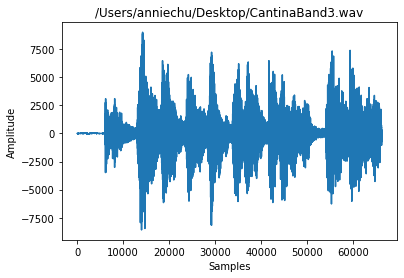

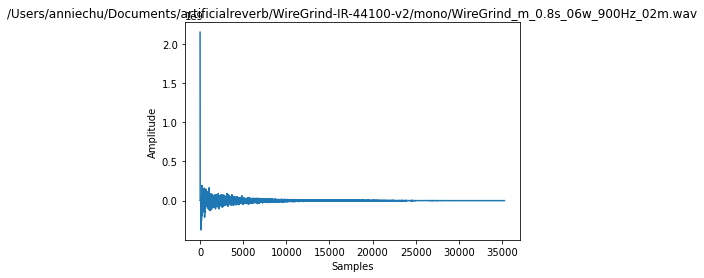

In [10]:
"""displaying contents"""
display_data(input_sig, showgraphs=True)
display_data(IR, showgraphs=True)

preparing files for convolution (making stereo, interpolating to same fs, normalizing)

In [11]:
#STEREO-IZING

In [12]:
"""making both stereo for simplicity"""
sig_i, sig_ifs = makestereo(input_sig)
ir_i, ir_ifs = makestereo(IR)

In [ ]:
"""playing stereo files"""
play_sig_i = play_sound(sig_i, sig_ifs)

In [ ]:
play_sig_i.stop()

In [ ]:
"""playing stereo files (cont.)"""
play_ir_i = play_sound(data_IR, fs_IR) #can sound bad

In [ ]:
play_ir_i.stop()

In [ ]:
#MATCHING FS -- INTERPOLATION

In [13]:
#pcm2float
"""
FUNCTION: using utility to convert int16 to float32 as convolving large numbers takes up too long
"""
def norm_signals(sig, IR):
    normalized_sig = utility.pcm2float(sig, "float32")
    normalized_IR = utility.pcm2float(IR, "float32")

    return normalized_sig, normalized_IR


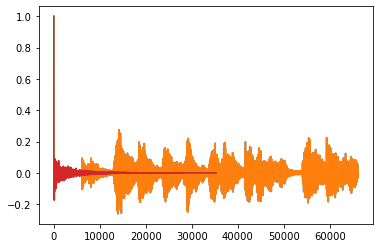

In [14]:
sig_inorm, ir_inorm = norm_signals(sig_i, ir_i)
plt.plot(sig_inorm)
plt.plot(ir_inorm)

In [26]:
from scipy.interpolate import interp1d
"""
upsampling dataset as given by match_fs function
"""
def upsample(sig1, sig1_fs, sig2, sig2_fs, showgraphs = False):
    upsamp, up_data, up_dataname, baseline_data = match_fs(sig1_fs, sig2_fs, sig1, sig2)
    
    k = np.arange(len(up_data))
    print(f"k = {k}")
    print(f"up_data[:,0] = {up_data[:,0]}")

    #inserting zeros in between original sample
    n = up_data.shape
    size = n[0]
    zeroed = np.zeros(upsamp*size, dtype = float)
    print(f"zeros = {zeroed}")
    zeroed = np.stack((zeroed, zeroed), axis = -1)
    zeroed[:,0][::upsamp] = up_data[:,0]
    print(f"updata[:,0] = {up_data[:,0]} ")
    zeroed[:,1][::upsamp] = up_data[:,1]
    print(f"zeroed inserted = {zeroed}")
    k_up = np.arange(len(zeroed))
    print(k_up)
    # print(k_up[zeroed[0]!=0])

    # # #upsampling & interpolation
    interp_L = np.interp(k_up, k_up[zeroed[:,0]!=0], zeroed[:,0][zeroed[:,0]!=0])
    interp_R = np.interp(k_up, k_up[zeroed[:,1]!=0], zeroed[:,1][zeroed[:,1]!=0])
    data_interp = np.stack((interp_L, interp_R) , axis = -1)
    print(f"New Upsamp&Interp Data = {data_interp}, upsamp factor = {upsamp}" )

    print(data_interp.dtype)
    if showgraphs==True:
        plt.figure() #original signal
        plt.plot(k,up_data)
        plt.ylim([-4000, 4000])
        plt.xlabel('Sample [k]')
        plt.ylabel('amplitude')
        plt.title('original signal')
        
        plt.figure() #upsampled signal -- inserted 0s
        plt.plot(k_up,out)
        plt.ylim([-4000, 4000])
        plt.xlabel('Sample [k]')
        plt.ylabel('amplitude')
        plt.title('upsampled signal')
        
        plt.figure() #interpolated signal -- output
        plt.plot(k_up,out)
        plt.plot(k_up, data_interp)
        plt.xlim([15000, 16000])
        plt.ylim([-4000, 4000])
        plt.xlabel('Sample [k]')
        plt.ylabel('amplitude')
        plt.title('interpolated signal')
        plt.legend(['upsampled', "interpolated"])
    

    return data_interp, baseline_data


k = [    0     1     2 ... 66147 66148 66149]
up_data[:,0] = [ 9.1552734e-05  2.1362305e-04  0.0000000e+00 ... -3.6621094e-04
 -1.3031006e-02 -6.9274902e-03]
zeros = [0. 0. 0. ... 0. 0. 0.]
updata[:,0] = [ 9.1552734e-05  2.1362305e-04  0.0000000e+00 ... -3.6621094e-04
 -1.3031006e-02 -6.9274902e-03] 
zeroed inserted = [[ 9.15527344e-05  9.15527344e-05]
 [ 0.00000000e+00  0.00000000e+00]
 [ 2.13623047e-04  2.13623047e-04]
 ...
 [ 0.00000000e+00  0.00000000e+00]
 [-6.92749023e-03 -6.92749023e-03]
 [ 0.00000000e+00  0.00000000e+00]]
[     0      1      2 ... 132297 132298 132299]
New Upsamp&Interp Data = [[ 9.15527344e-05  9.15527344e-05]
 [ 1.52587891e-04  1.52587891e-04]
 [ 2.13623047e-04  2.13623047e-04]
 ...
 [-9.97924805e-03 -9.97924805e-03]
 [-6.92749023e-03 -6.92749023e-03]
 [-6.92749023e-03 -6.92749023e-03]], upsamp factor = 2
float64


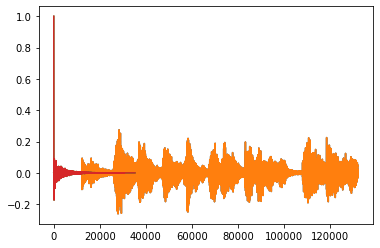

In [30]:
upsampled_sig1, sig2 = upsample(sig_inorm, sig_ifs, ir_inorm, ir_ifs)
plt.plot(upsampled_sig1)
plt.plot(sig2)

In [25]:
# up_data = np.array([0.9, 0.45, .02, .3, .4])
# up_data = np.stack((up_data, up_data), axis=-1)
# upsamp = 2

k = np.arange(len(up_data))
print(f"k = {k}")
print(f"up_data[:,0] = {up_data[:,0]}")

#inserting zeros in between original sample
n = up_data.shape
size = n[0]
zeroed = np.zeros(upsamp*size, dtype = float)
print(f"zeros = {zeroed}")
zeroed = np.stack((zeroed, zeroed), axis = -1)
zeroed[:,0][::upsamp] = up_data[:,0]
print(f"updata[:,0] = {up_data[:,0]} ")
zeroed[:,1][::upsamp] = up_data[:,1]
print(f"zeroed inserted = {zeroed}")
k_up = np.arange(len(zeroed))
print(k_up)
# print(k_up[zeroed[0]!=0])

# # #upsampling & interpolation
interp_L = np.interp(k_up, k_up[zeroed[:,0]!=0], zeroed[:,0][zeroed[:,0]!=0])
interp_R = np.interp(k_up, k_up[zeroed[:,1]!=0], zeroed[:,1][zeroed[:,1]!=0])
data_interp = np.stack((interp_L, interp_R) , axis = -1)
print(f"New Upsamp&Interp Data = {data_interp}, upsamp factor = {upsamp}" )

print(data_interp.dtype)


k = [    0     1     2 ... 66147 66148 66149]
up_data[:,0] = [   3    7    0 ...  -12 -427 -227]
zeros = [0. 0. 0. ... 0. 0. 0.]
updata[:,0] = [   3    7    0 ...  -12 -427 -227] 
zeroed inserted = [[   3.    3.]
 [   0.    0.]
 [   7.    7.]
 ...
 [   0.    0.]
 [-227. -227.]
 [   0.    0.]]
[     0      1      2 ... 132297 132298 132299]
New Upsamp&Interp Data = [[   3.    3.]
 [   5.    5.]
 [   7.    7.]
 ...
 [-327. -327.]
 [-227. -227.]
 [-227. -227.]], upsamp factor = 2
float64
